In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [2]:
def check_data_quality(df):
    print("The shape:")
    print(df.shape)

    missing_values = df.isna().sum()
    if missing_values.sum() == 0:
        print("\nNo missing values found.")
    else:
        print("Columns with missing values:")
        print(missing_values[missing_values != 0])

    print("\nData types:")
    print(df.dtypes)
    
    print("\nUnique types:")
    print(df.nunique())

    print("\nSummary Statistics:")
    df.describe()

    df.hist(bins=50, figsize=(20,15))
    
    
    
def position_to_number(pos):
    if pos == 'PG':
        return 1
    elif (pos == 'PG-SG' or pos == 'SG-PG'):
        return 1.5
    elif (pos == 'SG' or pos == 'SG-PG-SF'):
        return 2
    elif (pos == 'SG-SF' or pos == 'SF-SG'):
        return 2.5
    elif pos == 'SF':
        return 3
    elif pos == 'PF-SF':
        return 3.5
    elif pos == 'PF':
        return 4
    elif pos == 'C-PF':
        return 4.5
    elif pos == 'C':
        return 5
    
    
    
def add_target(group):
    group["target"] = group["WS"].shift(-1)
    group["target"].fillna(0, inplace=True)
    return group
    
    
    
def preprocess_df(data, Season):
    data.drop(data.columns[[19, 24, 29]], axis=1, inplace=True)
    data['Season'] = Season
    data['Pos'] = data['Pos'].apply(position_to_number)
    del data["Rk"]
    data = data.dropna()
    return data

In [3]:
df_2018 = preprocess_df(pd.read_csv("nba_player_2018.csv"), 2018)
df_2019 = preprocess_df(pd.read_csv("nba_player_2019.csv"), 2019)
df_2020 = preprocess_df(pd.read_csv("nba_player_2020.csv"), 2020)
df_2021 = preprocess_df(pd.read_csv("nba_player_2021.csv"), 2021)

In [4]:
df = pd.concat([df_2018, df_2019, df_2020, df_2021])

In [5]:
print(df.shape)

(701, 27)
(640, 27)
(698, 27)
(797, 27)
(2836, 27)


The shape:
(2836, 27)

No missing values found.

Data types:
Player     object
Pos       float64
Age         int64
Tm         object
G           int64
MP          int64
PER       float64
TS%       float64
3PAr      float64
FTr       float64
ORB%      float64
DRB%      float64
TRB%      float64
AST%      float64
STL%      float64
BLK%      float64
TOV%      float64
USG%      float64
OWS       float64
DWS       float64
WS        float64
WS/48     float64
OBPM      float64
DBPM      float64
BPM       float64
VORP      float64
Season      int64
dtype: object

Unique types:
Player     874
Pos          9
Age         25
Tm          31
G           82
MP        1547
PER        354
TS%        446
3PAr       752
FTr        559
ORB%       203
DRB%       328
TRB%       253
AST%       389
STL%        74
BLK%       105
TOV%       273
USG%       298
OWS        112
DWS         56
WS         135
WS/48      472
OBPM       247
DBPM       143
BPM        288
VORP        83
Season       4
dtype: int64

Summa

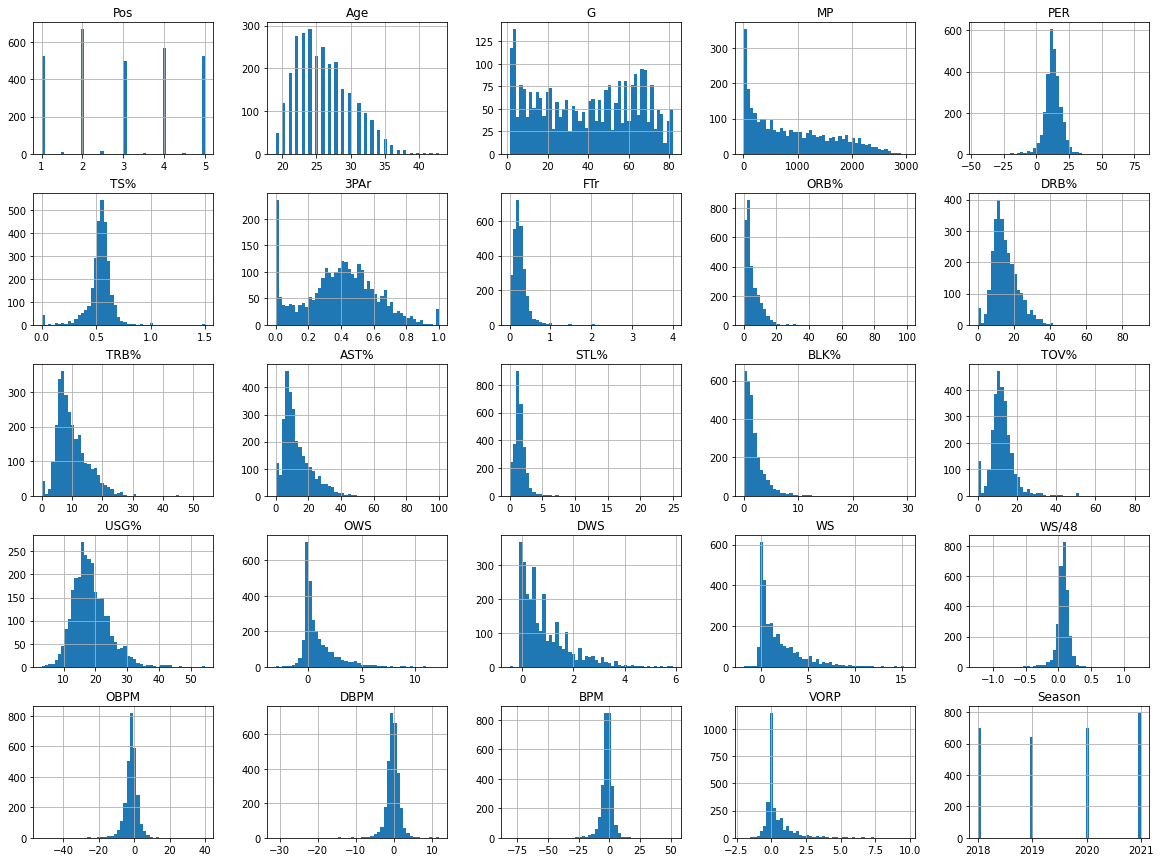

In [6]:
check_data_quality(df)

In [15]:
df = df.groupby("Player", group_keys=False).apply(add_target)
df['PER'].info()

AttributeError: 'Series' object has no attribute 'info'

# start ML

In [8]:
removed_columns = ['Player', 'Tm', 'target']
selected_columns = df.columns[~df.columns.isin(removed_columns)]
selected_columns

Index(['Pos', 'Age', 'G', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%',
       'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS',
       'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'Season'],
      dtype='object')

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Create a toy dataset
X = df[selected_columns].values
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression object and fit the model to the data
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [10]:
# Generate predictions on the test set
y_pred_test = lr.predict(X_test)

# Create a DataFrame containing the actual and predicted results
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test})

results_df['diff'] = results_df['Predicted'] - results_df['Actual']
results_df

,Actual,Predicted,diff
0,4.2,2.197489,-2.002511
1,0.0,0.763736,0.763736
2,1.6,1.801951,0.201951
3,3.3,1.311754,-1.988246
4,1.2,1.149650,-0.050350
...,...,...,...
563,0.0,1.476627,1.476627
564,0.4,1.524659,1.124659
565,0.0,0.406567,0.406567
566,0.0,1.184945,1.184945


In [11]:
results_df['diff'].describe()

count    568.000000
mean      -0.005003
std        1.442138
min       -5.710083
25%       -0.476451
50%        0.153037
75%        0.823713
max        5.700729
Name: diff, dtype: float64

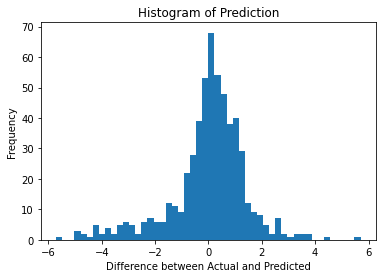

In [12]:
plt.hist(results_df['diff'], bins=50)
plt.xlabel('Difference between Actual and Predicted')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction')
plt.show()